In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import timeit
import sklearn.neural_network
import sklearn.linear_model


import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

seed_value= 105

import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)


import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib as mpl
# val_rnn_bad = 
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def createDataset(filename,num_data, delta_times,point_num):
    data = []
    for i in range(1,num_data+1):
        first_peak = 100

        read_input = pd.read_csv(filename, skiprows=7, header=None, sep='\s+')
#         print(read_input)

        for i in range(point_num):
            X_target = read_input[[0,i+1]]
            
            time = X_target[0]

            from scipy.signal import find_peaks
            peaks, _ = find_peaks(X_target[i+1], height=0)
            
            if first_peak>peaks[0]:
                first_peak = peaks[0]

        input_target = []
        for i in range(point_num):
            X_target = read_input[[0,i+1]]
            time = X_target[0]

            X_target = X_target[i+1][first_peak:]
            X_target = X_target.reset_index().drop('index', axis=1)
            X_target = X_target[i+1]

#             d = {'time':time, 'data': X_target}
            d = {'data': X_target}
            df = pd.DataFrame(data=d).dropna()
#             df['point'] = i+1
            df = df[:delta_times].values.T

            input_target.append(df)
        input_target = np.array(input_target).reshape(1,point_num,-1)

        data.append(input_target)

    data = np.array(data)
    X =[]
    for i in range(num_data):
        X.append(data[i].T)

    X = np.array(X).reshape(-1,delta_times,point_num)
    
#     Y = []
#     for i in range(1,num_data+1):
#         Y_target = pd.read_csv('../../'+folder+'/'+str(i)+'/DATA_TARGET.txt', skiprows=7, header=None, sep='\s+')
#         Y_target = Y_target[[0,1]]

#         array = Y_target[1].values.reshape(714,-1, order='F').T
#         actual_target = array[0]

#         Y.append([actual_target])
    
#     Y = np.array(Y).reshape(-1,714)

    return X

In [3]:
real_data_no_tide = createDataset('DATA_OBS_KRAKATAU.txt',1,80,4)
real_data_with_tide = createDataset('DATA_OBS.txt',1,80,4)

In [4]:
model = tf.keras.models.load_model('Model Tsunami LSTM.h5')
model.load_weights('Model Tsunami LSTM Weight.h5')

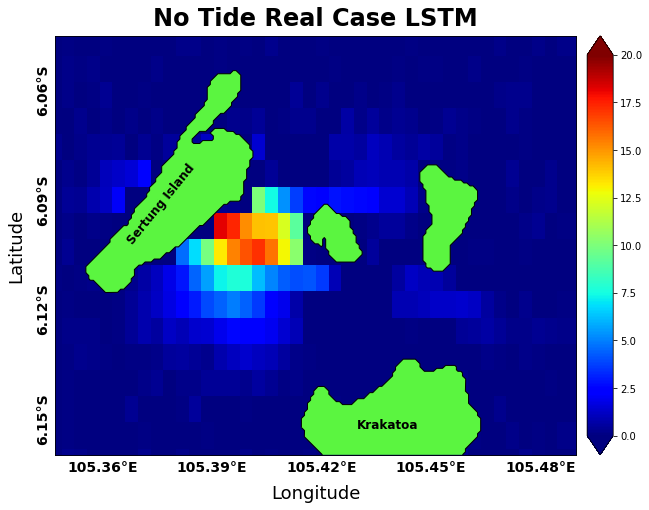

In [5]:
#Plot map
# -6.101818411822116, 105.42298712723777
lon = [105.4229]
lat = [-6.1018]

val_rnn_best = model.predict(real_data_no_tide).ravel()
val_rnn_best = val_rnn_best[:714]

top = -6.045
bottom = -6.16
left = 105.347
right = 105.49

# zoom = 0.01
# top = top - zo
# bottom = bottom
# left = left
# right = right

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)

m = Basemap(projection='mill', resolution="f", epsg=4326, 
            lat_0=sum(lat) / len(lat), lon_0=sum(lon) / len(lon),
           llcrnrlon = left,llcrnrlat = bottom,urcrnrlon = right,urcrnrlat = top)
# m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 2000, verbose= True

# m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 2000, verbose= True)
# x,y = m(lon[0], lat[0])
# plt.annotate('ADCP', xy=(x, y), xycoords='data', xytext=(-20, -20), textcoords='offset points', fontsize=16, fontweight='bold')

# x,y = m(96.18, 4.12)
# plt.annotate('Meulaboh', rotation=-45, xy=(x, y), xycoords='data', xytext=(0,0), textcoords='offset points', fontsize=16, fontweight='bold')
lon = np.linspace(left, right, 42)
lat = np.linspace(bottom, top, 17)
# x, y = m(lons, lats)

i = 0
for lons in lon :
    for lats in lat :
        x,y = m(lons, lats)
        plt.scatter(x, y, 1500, val_rnn_best[i], marker='s', vmin=0, vmax=10, cmap='jet')
#         print(val_rnn_best[i])
        i = i + 1

# i = 1
# for lons in lon :
#   for lats in lat :
#     x,y = m(lons, lats)
#     m.plot(x, y, 'rv', markersize=12)
#     plt.annotate('P'+str(i), xy=(x, y), xycoords='data', xytext=(-8, 8), textcoords='offset points', fontsize=16)
#     i += 1

x,y = m(105.432, -6.155)
plt.annotate('Krakatoa', xy=(x, y), xycoords='data', xytext=(-8, 8), textcoords='offset points', fontsize=12, fontweight='bold')

x,y = m(105.366, -6.102)
plt.annotate('Sertung Island', rotation=51, xy=(x, y), xycoords='data', xytext=(0,0), textcoords='offset points', fontsize=12, fontweight='bold')




# m.drawmapboundary(fill_color='#55d3f2',zorder=0)
m.drawcoastlines(color='black')
m.fillcontinents(color='#5bf540')



m.drawparallels(np.arange(-90,90,0.03),labels=[1,0,0,0], rotation=90, linewidth=0.0, fontsize=14, fontweight='bold')
m.drawmeridians(np.arange(-180,180,0.03),labels=[0,0,0,1], linewidth=0.0, fontsize=14, fontweight='bold')
        
plt.xlabel('Longitude', labelpad=30, fontsize=18)
plt.ylabel('Latitude', labelpad=30, fontsize=18)
plt.title('No Tide Real Case LSTM', fontsize=24, pad=10, fontweight='bold')


fraction = 1  # .05
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.15)
norm = mpl.colors.Normalize(vmin=0, vmax=20)
cbar = ax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap='jet'),
            ax=ax, pad=0.15, extend='both', fraction=fraction, cax=cax)

# plt.legend(['Wave','Wind'])
plt.savefig('Map_LSTM_real_notide.png', bbox_inches = 'tight', pad_inches = 0)


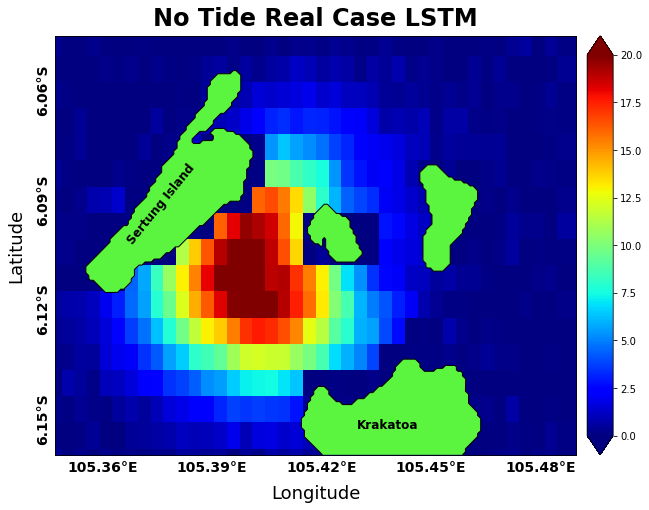

In [6]:
#Plot map
# -6.101818411822116, 105.42298712723777
lon = [105.4229]
lat = [-6.1018]

val_rnn_best = model.predict(real_data_with_tide).ravel()
val_rnn_best = val_rnn_best[:714]

top = -6.045
bottom = -6.16
left = 105.347
right = 105.49

# zoom = 0.01
# top = top - zo
# bottom = bottom
# left = left
# right = right

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)

m = Basemap(projection='mill', resolution="f", epsg=4326, 
            lat_0=sum(lat) / len(lat), lon_0=sum(lon) / len(lon),
           llcrnrlon = left,llcrnrlat = bottom,urcrnrlon = right,urcrnrlat = top)
# m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 2000, verbose= True

# m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 2000, verbose= True)
# x,y = m(lon[0], lat[0])
# plt.annotate('ADCP', xy=(x, y), xycoords='data', xytext=(-20, -20), textcoords='offset points', fontsize=16, fontweight='bold')

# x,y = m(96.18, 4.12)
# plt.annotate('Meulaboh', rotation=-45, xy=(x, y), xycoords='data', xytext=(0,0), textcoords='offset points', fontsize=16, fontweight='bold')
lon = np.linspace(left, right, 42)
lat = np.linspace(bottom, top, 17)
# x, y = m(lons, lats)

i = 0
for lons in lon :
    for lats in lat :
        x,y = m(lons, lats)
        plt.scatter(x, y, 1500, val_rnn_best[i], marker='s', vmin=0, vmax=10, cmap='jet')
#         print(val_rnn_best[i])
        i = i + 1

# i = 1
# for lons in lon :
#   for lats in lat :
#     x,y = m(lons, lats)
#     m.plot(x, y, 'rv', markersize=12)
#     plt.annotate('P'+str(i), xy=(x, y), xycoords='data', xytext=(-8, 8), textcoords='offset points', fontsize=16)
#     i += 1

x,y = m(105.432, -6.155)
plt.annotate('Krakatoa', xy=(x, y), xycoords='data', xytext=(-8, 8), textcoords='offset points', fontsize=12, fontweight='bold')

x,y = m(105.366, -6.102)
plt.annotate('Sertung Island', rotation=51, xy=(x, y), xycoords='data', xytext=(0,0), textcoords='offset points', fontsize=12, fontweight='bold')




# m.drawmapboundary(fill_color='#55d3f2',zorder=0)
m.drawcoastlines(color='black')
m.fillcontinents(color='#5bf540')



m.drawparallels(np.arange(-90,90,0.03),labels=[1,0,0,0], rotation=90, linewidth=0.0, fontsize=14, fontweight='bold')
m.drawmeridians(np.arange(-180,180,0.03),labels=[0,0,0,1], linewidth=0.0, fontsize=14, fontweight='bold')
        
plt.xlabel('Longitude', labelpad=30, fontsize=18)
plt.ylabel('Latitude', labelpad=30, fontsize=18)
plt.title('With Tide Real Case LSTM', fontsize=24, pad=10, fontweight='bold')


fraction = 1  # .05
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.15)
norm = mpl.colors.Normalize(vmin=0, vmax=20)
cbar = ax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap='jet'),
            ax=ax, pad=0.15, extend='both', fraction=fraction, cax=cax)

# plt.legend(['Wave','Wind'])
plt.savefig('Map_LSTM_real_withtide.png', bbox_inches = 'tight', pad_inches = 0)


In [7]:
model = tf.keras.models.load_model('Model Tsunami RNN.h5')
model.load_weights('Model Tsunami RNN Weight.h5')

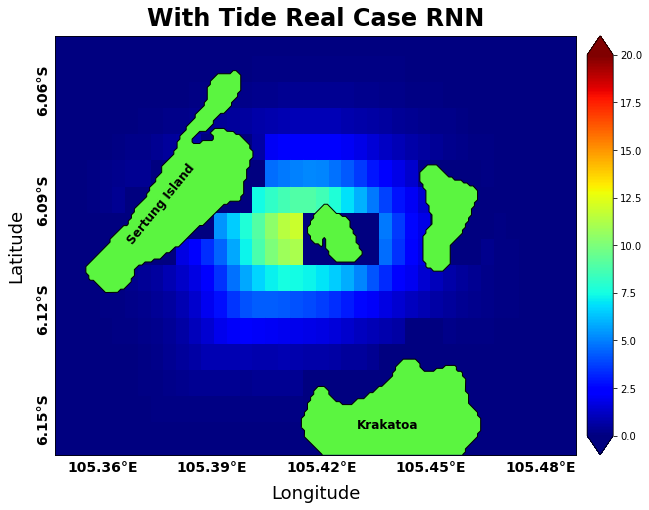

In [8]:
#Plot map
# -6.101818411822116, 105.42298712723777
lon = [105.4229]
lat = [-6.1018]

val_rnn_best = model.predict(real_data_no_tide).ravel()
val_rnn_best = val_rnn_best[:714]

top = -6.045
bottom = -6.16
left = 105.347
right = 105.49

# zoom = 0.01
# top = top - zo
# bottom = bottom
# left = left
# right = right

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)

m = Basemap(projection='mill', resolution="f", epsg=4326, 
            lat_0=sum(lat) / len(lat), lon_0=sum(lon) / len(lon),
           llcrnrlon = left,llcrnrlat = bottom,urcrnrlon = right,urcrnrlat = top)
# m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 2000, verbose= True

# m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 2000, verbose= True)
# x,y = m(lon[0], lat[0])
# plt.annotate('ADCP', xy=(x, y), xycoords='data', xytext=(-20, -20), textcoords='offset points', fontsize=16, fontweight='bold')

# x,y = m(96.18, 4.12)
# plt.annotate('Meulaboh', rotation=-45, xy=(x, y), xycoords='data', xytext=(0,0), textcoords='offset points', fontsize=16, fontweight='bold')
lon = np.linspace(left, right, 42)
lat = np.linspace(bottom, top, 17)
# x, y = m(lons, lats)

i = 0
for lons in lon :
    for lats in lat :
        x,y = m(lons, lats)
        plt.scatter(x, y, 1500, val_rnn_best[i], marker='s', vmin=0, vmax=10, cmap='jet')
#         print(val_rnn_best[i])
        i = i + 1

# i = 1
# for lons in lon :
#   for lats in lat :
#     x,y = m(lons, lats)
#     m.plot(x, y, 'rv', markersize=12)
#     plt.annotate('P'+str(i), xy=(x, y), xycoords='data', xytext=(-8, 8), textcoords='offset points', fontsize=16)
#     i += 1

x,y = m(105.432, -6.155)
plt.annotate('Krakatoa', xy=(x, y), xycoords='data', xytext=(-8, 8), textcoords='offset points', fontsize=12, fontweight='bold')

x,y = m(105.366, -6.102)
plt.annotate('Sertung Island', rotation=51, xy=(x, y), xycoords='data', xytext=(0,0), textcoords='offset points', fontsize=12, fontweight='bold')




# m.drawmapboundary(fill_color='#55d3f2',zorder=0)
m.drawcoastlines(color='black')
m.fillcontinents(color='#5bf540')



m.drawparallels(np.arange(-90,90,0.03),labels=[1,0,0,0], rotation=90, linewidth=0.0, fontsize=14, fontweight='bold')
m.drawmeridians(np.arange(-180,180,0.03),labels=[0,0,0,1], linewidth=0.0, fontsize=14, fontweight='bold')
        
plt.xlabel('Longitude', labelpad=30, fontsize=18)
plt.ylabel('Latitude', labelpad=30, fontsize=18)
plt.title('No Tide Real Case RNN', fontsize=24, pad=10, fontweight='bold')


fraction = 1  # .05
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.15)
norm = mpl.colors.Normalize(vmin=0, vmax=20)
cbar = ax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap='jet'),
            ax=ax, pad=0.15, extend='both', fraction=fraction, cax=cax)

# plt.legend(['Wave','Wind'])
plt.savefig('Map_RNN_real_notide.png', bbox_inches = 'tight', pad_inches = 0)


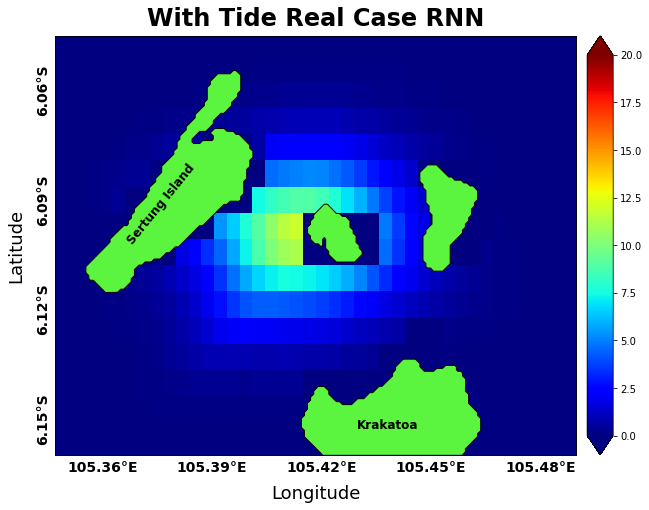

In [9]:
#Plot map
# -6.101818411822116, 105.42298712723777
lon = [105.4229]
lat = [-6.1018]

val_rnn_best = model.predict(real_data_with_tide).ravel()
val_rnn_best = val_rnn_best[:714]

top = -6.045
bottom = -6.16
left = 105.347
right = 105.49

# zoom = 0.01
# top = top - zo
# bottom = bottom
# left = left
# right = right

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)

m = Basemap(projection='mill', resolution="f", epsg=4326, 
            lat_0=sum(lat) / len(lat), lon_0=sum(lon) / len(lon),
           llcrnrlon = left,llcrnrlat = bottom,urcrnrlon = right,urcrnrlat = top)
# m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 2000, verbose= True

# m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 2000, verbose= True)
# x,y = m(lon[0], lat[0])
# plt.annotate('ADCP', xy=(x, y), xycoords='data', xytext=(-20, -20), textcoords='offset points', fontsize=16, fontweight='bold')

# x,y = m(96.18, 4.12)
# plt.annotate('Meulaboh', rotation=-45, xy=(x, y), xycoords='data', xytext=(0,0), textcoords='offset points', fontsize=16, fontweight='bold')
lon = np.linspace(left, right, 42)
lat = np.linspace(bottom, top, 17)
# x, y = m(lons, lats)

i = 0
for lons in lon :
    for lats in lat :
        x,y = m(lons, lats)
        plt.scatter(x, y, 1500, val_rnn_best[i], marker='s', vmin=0, vmax=10, cmap='jet')
#         print(val_rnn_best[i])
        i = i + 1

# i = 1
# for lons in lon :
#   for lats in lat :
#     x,y = m(lons, lats)
#     m.plot(x, y, 'rv', markersize=12)
#     plt.annotate('P'+str(i), xy=(x, y), xycoords='data', xytext=(-8, 8), textcoords='offset points', fontsize=16)
#     i += 1

x,y = m(105.432, -6.155)
plt.annotate('Krakatoa', xy=(x, y), xycoords='data', xytext=(-8, 8), textcoords='offset points', fontsize=12, fontweight='bold')

x,y = m(105.366, -6.102)
plt.annotate('Sertung Island', rotation=51, xy=(x, y), xycoords='data', xytext=(0,0), textcoords='offset points', fontsize=12, fontweight='bold')




# m.drawmapboundary(fill_color='#55d3f2',zorder=0)
m.drawcoastlines(color='black')
m.fillcontinents(color='#5bf540')



m.drawparallels(np.arange(-90,90,0.03),labels=[1,0,0,0], rotation=90, linewidth=0.0, fontsize=14, fontweight='bold')
m.drawmeridians(np.arange(-180,180,0.03),labels=[0,0,0,1], linewidth=0.0, fontsize=14, fontweight='bold')
        
plt.xlabel('Longitude', labelpad=30, fontsize=18)
plt.ylabel('Latitude', labelpad=30, fontsize=18)
plt.title('With Tide Real Case RNN', fontsize=24, pad=10, fontweight='bold')


fraction = 1  # .05
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.15)
norm = mpl.colors.Normalize(vmin=0, vmax=20)
cbar = ax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap='jet'),
            ax=ax, pad=0.15, extend='both', fraction=fraction, cax=cax)

# plt.legend(['Wave','Wind'])
plt.savefig('Map_RNN_real_withtide.png', bbox_inches = 'tight', pad_inches = 0)
